In [1]:
import tensorflow as tf
import os
import pickle
import numpy as np

In [2]:
CIFAR_DIR = '/home/commaai-03/Data/dataset/cifar-10-python'

def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

In [3]:
filenames = [os.path.join(CIFAR_DIR, file) 
             for file in os.listdir(CIFAR_DIR)
             if '.html' not in file]
filenames.sort()
meta_file = filenames[0]
train_files = filenames[1:-1]
test_file = [filenames[-1]]

In [4]:
_test_data = unpickle(test_file[0])
for k, v in _test_data.items():
    print(k)

b'batch_label'
b'labels'
b'data'
b'filenames'


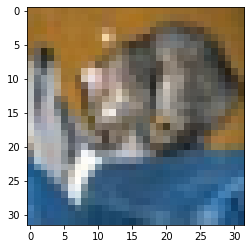

In [5]:
img_arr = _test_data[b'data'][0]
# 32 * 32 * 3 (R,G,B)
img_arr_reshaped = img_arr.reshape((3, 32, 32))
img = img_arr_reshaped.transpose(1, 2, 0)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
imshow(img)

In [6]:
class CifarData:
    
    def __init__(self, filenames, need_shuffle):
        all_data = []
        all_labels = []
        for filename in filenames:
            data, labels = self.load_data(filename)
            all_data.append(data)
            all_labels.append(labels)
        self._data = np.vstack(all_data)
        self._data = self._data / 127.5 - 1
        self._labels = np.hstack(all_labels)
        print('[CIFAR-10]: Data shape-> %s' % str(self._data.shape))
        print('[CIFAR-10]: Label shape-> %s' % str(self._labels.shape))
        
        self.num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
            
    def load_data(self, filename):
        import pickle
        with open(filename, mode='rb') as f:
            data = pickle.load(f, encoding='bytes')
        return data[b'data'], data[b'labels']
    
    def _shuffle_data(self):
        index = np.random.permutation(self.num_examples)
        self._data = self._data[index]
        self._labels = self._labels[index]
        
    def next_batch(self, batch_size):
        end_indicator = self._indicator + batch_size
        if end_indicator > self.num_examples:
            rest_num_examples = self.num_examples - self._indicator
            data_rest_part = self._data[self._indicator: self.num_examples]
            label_rest_part = self._labels[self._indicator: self.num_examples]
            
            if self._need_shuffle:
                self._shuffle_data()
            # For new loop, self._indicator + batch_size = self.num_examples
            self._indicator = batch_size - rest_num_examples
            end_indicator = self._indicator
            data_new_part = self._data[:end_indicator]
            label_new_part = self._labels[:end_indicator]
            batch_data = np.concatenate((data_rest_part, data_new_part), axis=0)
            batch_label = np.concatenate((label_rest_part, label_new_part), axis=0)
        else:
            batch_data = self._data[self._indicator:end_indicator]
            batch_label = self._labels[self._indicator:end_indicator]
            self._indicator = end_indicator
        
        return batch_data, batch_label

In [7]:
train_data = CifarData(train_files, need_shuffle=True)
test_data = CifarData(test_file, need_shuffle=False)

[CIFAR-10]: Data shape-> (50000, 3072)
[CIFAR-10]: Label shape-> (50000,)
[CIFAR-10]: Data shape-> (10000, 3072)
[CIFAR-10]: Label shape-> (10000,)


In [8]:
def separable_conv_block(x, 
                         output_channel_number, name):
    '''
    Args:
    - x:
    - output_channel_number:
    - name:
    '''
    with tf.variable_scope(name):
        input_channel = x.get_shape().as_list()[-1]
        #
        channel_wise_x = tf.split(x, input_channel, axis=3)
        output_channels = []
        for i in range(len(channel_wise_x)):
            output_channel = tf.keras.layers.Conv2D(filters=1, 
                                kernel_size=(3,3),
                                strides=(1,1), 
                                padding='same', 
                                activation=tf.nn.relu, 
                                name='conv_%d' % i)(channel_wise_x[i])
            output_channels.append(output_channel)
        concat_layer = tf.concat(output_channels, axis=3)
        conv1_1 = tf.keras.layers.Conv2D(
                filters=output_channel_number, 
                kernel_size=(1,1), strides=(1,1), 
                padding='same', 
                activation=tf.nn.relu, name='conv1_1')(concat_layer)
    return conv1_1

In [9]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 3072])
y = tf.placeholder(dtype=tf.int64, shape=[None])

x_img = tf.reshape(tensor=x, shape=[-1, 3, 32, 32])
# x_img: [None, 32, 32, 3]
x_img = tf.transpose(x_img, perm=[0, 2, 3, 1])

# conv1: feature map. [None, 32, 32, 32]
conv1 = tf.keras.layers.Conv2D(filters=32, 
                               kernel_size=(3,3), 
                               padding='same', 
                               activation=tf.nn.relu, 
                               name='conv1')(x_img)
# pooling1: [None, 16, 16, 32]
pooling1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), 
                                        strides=(2,2))(conv1)

# separable_2a and 2b [None, 16, 16, 32]
separable_2a = separable_conv_block(x=pooling1, 
                                    output_channel_number=32, 
                                    name='separable_2a')
separable_2b = separable_conv_block(x=separable_2a, 
                                    output_channel_number=32, 
                                    name='separable_2b')

# pooling2: [None, 8, 8, 32]
pooling2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), 
                                        strides=(2,2))(separable_2b)

# separable_3a and 3b [None, 8, 8, 32]
separable_3a = separable_conv_block(x=pooling2,
                                    output_channel_number=32,
                                    name='separable_3a')
separable_3b = separable_conv_block(x=separable_3a, 
                                     output_channel_number=32, 
                                     name='separable_3b')

# pooling3: [None, 4, 4, 32]
pooling3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), 
                                        strides=(2,2))(separable_3b)

# flatten: [512 * None,]
flatten = tf.keras.layers.Flatten()(pooling3)
# Dense: [10,]
y_ = tf.keras.layers.Dense(units=10)(flatten)

_loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

predict = tf.argmax(y_, 1)
correct_prediction = tf.equal(predict, y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(_loss)

W0924 11:55:36.233151 140317871028032 deprecation.py:506] From /home/commaai-03/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0924 11:55:37.698521 140317871028032 deprecation.py:323] From /home/commaai-03/.local/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
init = tf.global_variables_initializer()
batch_size = 20
train_steps = 100000
test_steps = 2000

with tf.Session() as sess:
    sess.run(init)
    for i in range(train_steps):
        batch_data, batch_labels = train_data.next_batch(batch_size)
        loss, acc, _ = sess.run([_loss, accuracy, train_op], 
                                feed_dict={x: batch_data, y: batch_labels})
        
        if (i+1) % 100 == 0:
            print('[Train]: Step: %d, loss: %4.5f acc: %4.5f' 
                  % (i+1, loss, acc))
        if (i+1) % 1000 == 0:
            all_test_acc_val = []
            for j in range(test_steps):
                test_batch_data, test_batch_labels = test_data.next_batch(batch_size)
                test_acc_val = sess.run([accuracy], 
                                        feed_dict={x: test_batch_data, y: test_batch_labels})
                all_test_acc_val.append(test_acc_val)
            test_acc = np.mean(all_test_acc_val)
            print('[Test] Step: %d, acc: %4.5f' % (i+1, test_acc))

[Train]: Step: 100, loss: 2.31312 acc: 0.10000
[Train]: Step: 200, loss: 2.12169 acc: 0.10000
[Train]: Step: 300, loss: 1.85917 acc: 0.35000
[Train]: Step: 400, loss: 1.41616 acc: 0.40000
[Train]: Step: 500, loss: 2.22816 acc: 0.20000
[Train]: Step: 600, loss: 1.76293 acc: 0.40000
[Train]: Step: 700, loss: 1.39598 acc: 0.60000
[Train]: Step: 800, loss: 1.70677 acc: 0.50000
[Train]: Step: 900, loss: 1.33551 acc: 0.55000
[Train]: Step: 1000, loss: 1.41636 acc: 0.45000
[Test] Step: 1000, acc: 0.47280
[Train]: Step: 1100, loss: 1.58659 acc: 0.30000
[Train]: Step: 1200, loss: 1.76952 acc: 0.35000
[Train]: Step: 1300, loss: 1.45533 acc: 0.45000
[Train]: Step: 1400, loss: 1.47931 acc: 0.40000
[Train]: Step: 1500, loss: 1.14052 acc: 0.70000
[Train]: Step: 1600, loss: 1.65458 acc: 0.45000
[Train]: Step: 1700, loss: 1.23242 acc: 0.50000
[Train]: Step: 1800, loss: 1.43847 acc: 0.50000
[Train]: Step: 1900, loss: 1.19096 acc: 0.55000
[Train]: Step: 2000, loss: 1.11585 acc: 0.55000
[Test] Step: 2000

[Test] Step: 16000, acc: 0.65250
[Train]: Step: 16100, loss: 0.98914 acc: 0.65000
[Train]: Step: 16200, loss: 0.78500 acc: 0.70000
[Train]: Step: 16300, loss: 0.84609 acc: 0.80000
[Train]: Step: 16400, loss: 1.11363 acc: 0.55000
[Train]: Step: 16500, loss: 0.56735 acc: 0.80000
[Train]: Step: 16600, loss: 0.75723 acc: 0.75000
[Train]: Step: 16700, loss: 0.82767 acc: 0.65000
[Train]: Step: 16800, loss: 1.03974 acc: 0.65000
[Train]: Step: 16900, loss: 0.67514 acc: 0.90000
[Train]: Step: 17000, loss: 0.95437 acc: 0.65000
[Test] Step: 17000, acc: 0.62370
[Train]: Step: 17100, loss: 0.62143 acc: 0.85000
[Train]: Step: 17200, loss: 1.20546 acc: 0.55000
[Train]: Step: 17300, loss: 0.96081 acc: 0.60000
[Train]: Step: 17400, loss: 0.67683 acc: 0.80000
[Train]: Step: 17500, loss: 0.72604 acc: 0.85000
[Train]: Step: 17600, loss: 0.36471 acc: 0.90000
[Train]: Step: 17700, loss: 0.89433 acc: 0.55000
[Train]: Step: 17800, loss: 1.13587 acc: 0.70000
[Train]: Step: 17900, loss: 1.16812 acc: 0.75000
[Tr

[Train]: Step: 31800, loss: 0.71257 acc: 0.70000
[Train]: Step: 31900, loss: 1.12327 acc: 0.55000
[Train]: Step: 32000, loss: 0.41855 acc: 0.85000
[Test] Step: 32000, acc: 0.67810
[Train]: Step: 32100, loss: 1.32286 acc: 0.60000
[Train]: Step: 32200, loss: 0.75725 acc: 0.75000
[Train]: Step: 32300, loss: 0.59772 acc: 0.80000
[Train]: Step: 32400, loss: 0.41685 acc: 0.85000
[Train]: Step: 32500, loss: 0.84099 acc: 0.75000
[Train]: Step: 32600, loss: 1.03620 acc: 0.75000
[Train]: Step: 32700, loss: 0.72760 acc: 0.85000
[Train]: Step: 32800, loss: 0.57830 acc: 0.80000
[Train]: Step: 32900, loss: 1.24137 acc: 0.40000
[Train]: Step: 33000, loss: 0.64537 acc: 0.75000
[Test] Step: 33000, acc: 0.68650
[Train]: Step: 33100, loss: 0.88770 acc: 0.70000
[Train]: Step: 33200, loss: 0.87791 acc: 0.70000
[Train]: Step: 33300, loss: 0.91494 acc: 0.60000
[Train]: Step: 33400, loss: 0.82586 acc: 0.70000
[Train]: Step: 33500, loss: 0.75836 acc: 0.80000
[Train]: Step: 33600, loss: 1.01877 acc: 0.65000
[Tr

[Train]: Step: 47500, loss: 0.82158 acc: 0.65000
[Train]: Step: 47600, loss: 0.55418 acc: 0.75000
[Train]: Step: 47700, loss: 0.54107 acc: 0.80000
[Train]: Step: 47800, loss: 0.65212 acc: 0.80000
[Train]: Step: 47900, loss: 1.07867 acc: 0.70000
[Train]: Step: 48000, loss: 0.60550 acc: 0.70000
[Test] Step: 48000, acc: 0.70600
[Train]: Step: 48100, loss: 0.62540 acc: 0.85000
[Train]: Step: 48200, loss: 0.59075 acc: 0.90000
[Train]: Step: 48300, loss: 0.47019 acc: 0.85000
[Train]: Step: 48400, loss: 0.51732 acc: 0.85000
[Train]: Step: 48500, loss: 0.84916 acc: 0.65000
[Train]: Step: 48600, loss: 1.22105 acc: 0.60000
[Train]: Step: 48700, loss: 0.77431 acc: 0.70000
[Train]: Step: 48800, loss: 0.58187 acc: 0.90000
[Train]: Step: 48900, loss: 0.45699 acc: 0.80000
[Train]: Step: 49000, loss: 0.79965 acc: 0.65000
[Test] Step: 49000, acc: 0.69350
[Train]: Step: 49100, loss: 0.68558 acc: 0.65000
[Train]: Step: 49200, loss: 0.96451 acc: 0.70000
[Train]: Step: 49300, loss: 0.93605 acc: 0.60000
[Tr

[Train]: Step: 63200, loss: 0.51676 acc: 0.85000
[Train]: Step: 63300, loss: 0.53165 acc: 0.75000
[Train]: Step: 63400, loss: 0.45421 acc: 0.80000
[Train]: Step: 63500, loss: 0.74046 acc: 0.70000
[Train]: Step: 63600, loss: 0.96925 acc: 0.70000
[Train]: Step: 63700, loss: 0.49509 acc: 0.85000
[Train]: Step: 63800, loss: 0.44101 acc: 0.90000
[Train]: Step: 63900, loss: 1.39014 acc: 0.70000
[Train]: Step: 64000, loss: 0.47966 acc: 0.75000
[Test] Step: 64000, acc: 0.70100
[Train]: Step: 64100, loss: 0.35832 acc: 0.90000
[Train]: Step: 64200, loss: 0.53211 acc: 0.80000
[Train]: Step: 64300, loss: 0.86926 acc: 0.85000
[Train]: Step: 64400, loss: 0.75079 acc: 0.90000
[Train]: Step: 64500, loss: 0.77680 acc: 0.80000
[Train]: Step: 64600, loss: 0.74923 acc: 0.75000
[Train]: Step: 64700, loss: 0.74941 acc: 0.65000
[Train]: Step: 64800, loss: 0.74451 acc: 0.70000
[Train]: Step: 64900, loss: 1.14956 acc: 0.65000
[Train]: Step: 65000, loss: 0.68938 acc: 0.70000
[Test] Step: 65000, acc: 0.69670
[Tr

[Train]: Step: 79000, loss: 1.10421 acc: 0.60000
[Test] Step: 79000, acc: 0.70970
[Train]: Step: 79100, loss: 0.74132 acc: 0.70000
[Train]: Step: 79200, loss: 0.56104 acc: 0.80000
[Train]: Step: 79300, loss: 0.86082 acc: 0.60000
[Train]: Step: 79400, loss: 0.59912 acc: 0.80000
[Train]: Step: 79500, loss: 0.96984 acc: 0.60000
[Train]: Step: 79600, loss: 0.66733 acc: 0.65000
[Train]: Step: 79700, loss: 0.35168 acc: 0.95000
[Train]: Step: 79800, loss: 0.54890 acc: 0.80000
[Train]: Step: 79900, loss: 0.84817 acc: 0.70000
[Train]: Step: 80000, loss: 1.10721 acc: 0.75000
[Test] Step: 80000, acc: 0.70560
[Train]: Step: 80100, loss: 0.49094 acc: 0.80000
[Train]: Step: 80200, loss: 1.07785 acc: 0.70000
[Train]: Step: 80300, loss: 0.40551 acc: 0.85000
[Train]: Step: 80400, loss: 0.47165 acc: 0.80000
[Train]: Step: 80500, loss: 0.59790 acc: 0.70000
[Train]: Step: 80600, loss: 0.75118 acc: 0.70000
[Train]: Step: 80700, loss: 0.59679 acc: 0.75000
[Train]: Step: 80800, loss: 0.32129 acc: 0.95000
[Tr

[Train]: Step: 94700, loss: 0.68642 acc: 0.90000
[Train]: Step: 94800, loss: 0.88035 acc: 0.65000
[Train]: Step: 94900, loss: 0.50002 acc: 0.90000
[Train]: Step: 95000, loss: 0.76578 acc: 0.70000
[Test] Step: 95000, acc: 0.70250
[Train]: Step: 95100, loss: 0.77127 acc: 0.75000
[Train]: Step: 95200, loss: 0.73945 acc: 0.80000
[Train]: Step: 95300, loss: 0.86051 acc: 0.55000
[Train]: Step: 95400, loss: 0.81165 acc: 0.65000
[Train]: Step: 95500, loss: 0.58646 acc: 0.70000
[Train]: Step: 95600, loss: 0.68866 acc: 0.80000
[Train]: Step: 95700, loss: 0.36892 acc: 0.90000
[Train]: Step: 95800, loss: 0.67049 acc: 0.75000
[Train]: Step: 95900, loss: 0.29269 acc: 0.90000
[Train]: Step: 96000, loss: 0.29585 acc: 0.90000
[Test] Step: 96000, acc: 0.70310
[Train]: Step: 96100, loss: 0.64523 acc: 0.90000
[Train]: Step: 96200, loss: 0.78802 acc: 0.65000
[Train]: Step: 96300, loss: 0.48411 acc: 0.80000
[Train]: Step: 96400, loss: 0.71207 acc: 0.60000
[Train]: Step: 96500, loss: 0.73336 acc: 0.80000
[Tr